# 0. 한글 대응

In [ ]:
!pip install koreanize-matplotlib
import matplotlib.pyplot as plt
import koreanize_matplotlib

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 설치된 폰트 목록에서 NanumGothic이 있는지 확인
[f.name for f in fm.fontManager.ttflist if 'Nanum' in f.name]

['NanumGothic', 'NanumGothic', 'NanumGothic', 'NanumGothic']

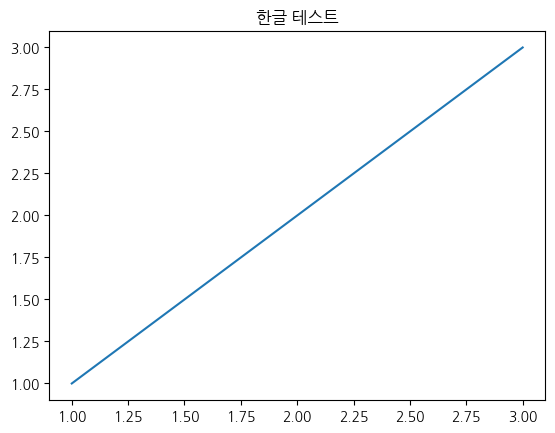

In [ ]:
plt.rc('font', family='NanumGothic')

# 한글 테스트
plt.title('한글 테스트')
plt.plot([1, 2, 3], [1, 2, 3])
plt.show()

# 1. 데이터 불러오기

In [ ]:
# 구글 드라이브 마운트

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 구글드라이브에 있는 dataset.zip 압축해제하여 content/dataset에 저장

!unzip /content/drive/MyDrive/output.zip -d /content/drive/MyDrive/kfooddata

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/drive/MyDrive/kfooddata/output/조림/장조림/Img_115_0153.jpg  
  inflating: /content/drive/MyDrive/kfooddata/output/조림/장조림/Img_115_0154.jpg  
  inflating: /content/drive/MyDrive/kfooddata/output/조림/장조림/Img_115_0155.jpg  
  inflating: /content/drive/MyDrive/kfooddata/output/조림/장조림/Img_115_0156.jpg  
  inflating: /content/drive/MyDrive/kfooddata/output/조림/장조림/Img_115_0158.jpg  
  inflating: /content/drive/MyDrive/kfooddata/output/조림/장조림/Img_115_0160.jpg  
  inflating: /content/drive/MyDrive/kfooddata/output/조림/장조림/Img_115_0163.jpg  
  inflating: /content/drive/MyDrive/kfooddata/output/조림/장조림/Img_115_0164.jpg  
  inflating: /content/drive/MyDrive/kfooddata/output/조림/장조림/Img_115_0167.jpg  
  inflating: /content/drive/MyDrive/kfooddata/output/조림/장조림/Img_115_0168.jpg  
  inflating: /content/drive/MyDrive/kfooddata/output/조림/장조림/Img_115_0169.jpg  
  inflating: /content/drive/MyDrive/kfooddata/output/조림/장조림/Img_115_0170.jpg  
  inflating: /co

In [ ]:
import os

# 경로 설정
folder_path = '/content/drive/MyDrive/kfooddata/output/'

# empty_labeling 파일 개수 세기 (재귀적으로 모든 하위 디렉토리까지 포함)
def count_files_in_folder(folder_path):
    file_count = 0
    for root, dirs, files in os.walk(folder_path):
        file_count += len([f for f in files if os.path.isfile(os.path.join(root, f))])
    return file_count

if os.path.exists(folder_path):
    num_files = count_files_in_folder(folder_path)
    print(f"Total number of files: {num_files}")
else:
    print(f"The folder path {folder_path} does not exist.")

Total number of files: 98897


In [ ]:
# 참고 : 모델 돌리기 전 Colab 런타임 안끊기게 하는 법
# https://dacon.io/forum/405904
# https://sjkoding.tistory.com/79

# 2. 해물 카테고리로 테스트

In [ ]:
# ResNet 모델링 코드
# 해물 카테고리만 학습하기(테스트)

import os
from PIL import Image
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.models import resnet18

# 이미지 경로와 라벨을 자동으로 생성하는 함수
def create_image_label_list(root_dir):
    image_paths = []
    labels = []
    label_dict = {}
    label_id = 0

    for root, dirs, files in os.walk(root_dir):
        # 각 폴더를 카테고리로 처리
        if files:
            category = os.path.basename(root)
            if category not in label_dict:
                label_dict[category] = label_id
                label_id += 1
            # 파일이 있는 경우에만 이미지 경로와 라벨 추가
            for file in files:
                # 이미지 파일일 때만 처리
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(root, file))
                    labels.append(label_dict[category])

    return image_paths, labels, label_dict

# 데이터셋 클래스 정의
class KoreanFoodDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# ResNet 모델 설정
def get_resnet_model(num_classes):
    model = resnet18(pretrained=True)
    in_features = model.fc.in_features
    model.fc = torch.nn.Linear(in_features, num_classes)
    return model

# 학습 및 평가 함수
def train_model(model, train_loader, valid_loader, num_epochs, device):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    best_accuracy = 0
    best_model_wts = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Training loop
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation loop
        model.eval()
        total = 0
        correct = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        validation_acc = 100 * correct / total if total > 0 else 0
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Validation Accuracy: {validation_acc:.2f}%")

        # 성능이 더 좋으면 저장
        if validation_acc > best_accuracy:
            best_accuracy = validation_acc
            best_model_wts = model.state_dict()

    # 성능이 가장 좋았던 모델 저장
    torch.save(best_model_wts, '/content/drive/MyDrive/resnet_output/korean_food_resnet_best_seafood.pth')

# 경로 설정 및 데이터 준비
root_dir = '/content/drive/MyDrive/kfooddata/output/해물'

# 이미지 경로와 라벨 생성
image_paths, labels, label_dict = create_image_label_list(root_dir)
print(f"총 {len(image_paths)}개의 유효한 이미지가 발견되었습니다.")

# 이미지 크기 조정 및 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet의 기본 입력 크기는 224x224
    transforms.ToTensor()
])

# 데이터셋 및 DataLoader 준비
dataset = KoreanFoodDataset(image_paths, labels, transform=transform)

# 데이터셋 나누기 (데이터가 충분하지 않은 경우 나누기 어려움)
train_size = int(0.7 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

# 모델 설정 및 학습
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = len(label_dict)  # 카테고리 수
model = get_resnet_model(num_classes)
model.to(device)

# 학습 시작
train_model(model, train_loader, valid_loader, num_epochs=10, device=device)

# 학습된 모델 저장
torch.save(model.state_dict(), '/content/drive/MyDrive/resnet_output/korean_food_resnet_full_seafood.pth')

총 1034개의 유효한 이미지가 발견되었습니다.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.3706, Validation Accuracy: 96.46%
Epoch [2/10], Loss: 0.0879, Validation Accuracy: 97.43%
Epoch [3/10], Loss: 0.0474, Validation Accuracy: 98.07%
Epoch [4/10], Loss: 0.0741, Validation Accuracy: 98.39%
Epoch [5/10], Loss: 0.0336, Validation Accuracy: 98.71%
Epoch [6/10], Loss: 0.0205, Validation Accuracy: 98.39%
Epoch [7/10], Loss: 0.0159, Validation Accuracy: 98.39%
Epoch [8/10], Loss: 0.0140, Validation Accuracy: 98.39%
Epoch [9/10], Loss: 0.0116, Validation Accuracy: 98.39%
Epoch [10/10], Loss: 0.0848, Validation Accuracy: 98.07%


In [ ]:
# 경로 설정 및 데이터 준비
root_dir = '/content/drive/MyDrive/kfooddata/output/해물'

# 이미지 경로와 라벨 생성
image_paths, labels, label_dict = create_image_label_list(root_dir)

# label_dict를 출력하여 확인
print("Label Dictionary:", label_dict)
print(f"총 {len(image_paths)}개의 유효한 이미지가 발견되었습니다.")

Label Dictionary: {'멍게': 0, '산낙지': 1}
총 1034개의 유효한 이미지가 발견되었습니다.


Incorrectly classified images:


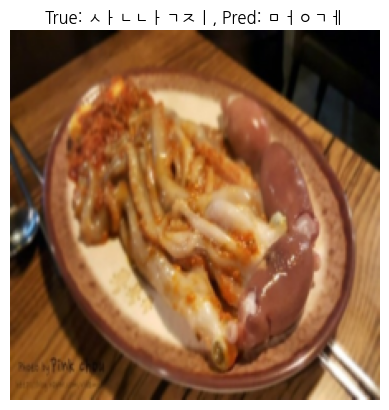

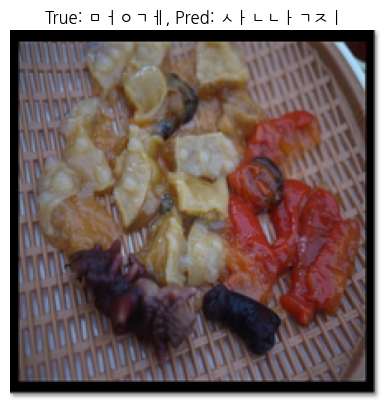

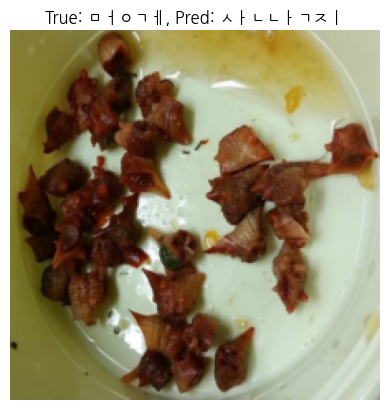

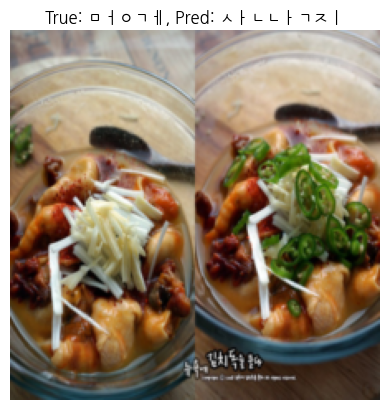

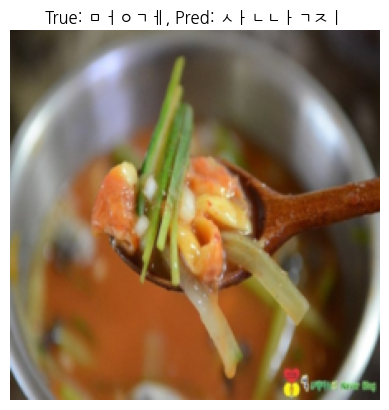

In [ ]:
# 해물 틀린 이미지 출력 테스트

import matplotlib.pyplot as plt

# 이미지를 보여주는 함수 정의
def show_image(image, label, pred_label=None):
    image = image.permute(1, 2, 0).cpu().numpy()  # Tensor를 이미지로 변환
    plt.imshow(image)
    if pred_label is not None:
        plt.title(f"True: {label}, Pred: {pred_label}")
    else:
        plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

# 맞춘 사진과 틀린 사진 출력
def visualize_predictions(model, data_loader, label_dict, device):
    model.eval()
    incorrect_images = []

    # label_dict의 값을 뒤집어서 인덱스 값을 바로 가져올 수 있도록 변경
    inv_label_dict = {v: k for k, v in label_dict.items()}

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # 맞춘 이미지와 틀린 이미지를 구분
            for i in range(len(images)):
                label_value = labels[i].item()
                pred_value = predicted[i].item()

                # inv_label_dict에서 매칭되는 레이블 찾기
                if label_value in inv_label_dict:
                    label = inv_label_dict[label_value]
                else:
                    print(f"True label {label_value} not found in inv_label_dict")
                    continue

                if pred_value in inv_label_dict:
                    pred_label = inv_label_dict[pred_value]
                else:
                    print(f"Predicted label {pred_value} not found in inv_label_dict")
                    continue

                # 틀린 이미지를 수집
                if pred_value != label_value:
                    incorrect_images.append((images[i], label, pred_label))

    # 틀린 사진 예시 출력
    print("Incorrectly classified images:")
    for img, label, pred in incorrect_images[:5]:  # 처음 5개만 예시로 출력
        show_image(img, label, pred)

# 모델 시각화
visualize_predictions(model, valid_loader, label_dict, device)


# 3. 전체 데이터 돌려보기

In [ ]:
# 경로 설정 및 데이터 준비
root_dir = '/content/drive/MyDrive/kfooddata/output/'

# 이미지 경로와 라벨 생성
image_paths, labels, label_dict = create_image_label_list(root_dir)

# label_dict를 출력하여 확인
print("Label Dictionary:", label_dict)
print(f"총 {len(image_paths)}개의 유효한 이미지가 발견되었습니다.")

Label Dictionary: {'갈비구이': 0, '갈치구이': 1, '고등어구이': 2, '곱창구이': 3, '닭갈비': 4, '더덕구이': 5, '떡갈비': 6, '불고기': 7, '삼겹살': 8, '장어구이': 9, '조개구이': 10, '조기구이': 11, '황태구이': 12, '훈제오리': 13, '계란국': 14, '떡국_만두국': 15, '무국': 16, '미역국': 17, '북엇국': 18, '시래기국': 19, '육개장': 20, '콩나물국': 21, '과메기': 22, '양념치킨': 23, '젓갈': 24, '콩자반': 25, '편육': 26, '피자': 27, '후라이드치킨': 28, '갓김치': 29, '깍두기': 30, '나박김치': 31, '무생채': 32, '배추김치': 33, '백김치': 34, '부추김치': 35, '열무김치': 36, '오이소박이': 37, '총각김치': 38, '파김치': 39, '가지볶음': 40, '고사리나물': 41, '미역줄기볶음': 42, '숙주나물': 43, '시금치나물': 44, '애호박볶음': 45, '경단': 46, '꿀떡': 47, '송편': 48, '만두': 49, '라면': 50, '막국수': 51, '물냉면': 52, '비빔냉면': 53, '수제비': 54, '열무국수': 55, '잔치국수': 56, '짜장면': 57, '짬뽕': 58, '쫄

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.models import resnet18
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 이미지 경로와 라벨을 자동으로 생성하는 함수
def create_image_label_list(root_dir):
    image_paths = []
    labels = []
    label_dict = {}
    label_id = 0

    for root, dirs, files in os.walk(root_dir):
        if files:
            category = os.path.basename(root)
            if category not in label_dict:
                label_dict[category] = label_id
                label_id += 1
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(root, file))
                    labels.append(label_dict[category])

    return image_paths, labels, label_dict

# 데이터셋 클래스 정의
class KoreanFoodDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# ResNet 모델 설정
def get_resnet_model(num_classes):
    model = resnet18(pretrained=True)
    in_features = model.fc.in_features
    model.fc = torch.nn.Linear(in_features, num_classes)
    return model

# 학습 및 평가 함수
def train_model(model, train_loader, valid_loader, num_epochs, device):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    best_accuracy = 0
    best_model_wts = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation loop
        model.eval()
        total = 0
        correct = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        validation_acc = 100 * correct / total if total > 0 else 0
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Validation Accuracy: {validation_acc:.2f}%")

        if validation_acc > best_accuracy:
            best_accuracy = validation_acc
            best_model_wts = model.state_dict()

    torch.save(best_model_wts, '/content/drive/MyDrive/resnet_output/korean_food_resnet_best.pth')

# 맞춘 사진과 틀린 사진을 출력하는 함수
def show_image(image, label, pred_label=None):
    image = image.permute(1, 2, 0).cpu().numpy()
    plt.imshow(image)
    if pred_label is not None:
        plt.title(f"True: {label}, Pred: {pred_label}")
    else:
        plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

# 맞춘 사진과 틀린 사진 출력
def visualize_predictions(model, data_loader, label_dict, device):
    model.eval()
    correct_images = []
    incorrect_images = []
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            for i in range(len(images)):
                label = list(label_dict.keys())[list(label_dict.values()).index(labels[i].item())]
                pred_label = list(label_dict.keys())[list(label_dict.values()).index(predicted[i].item())]

                true_labels.append(labels[i].item())
                pred_labels.append(predicted[i].item())

                if predicted[i] == labels[i]:
                    correct_images.append((images[i], label, pred_label))
                else:
                    incorrect_images.append((images[i], label, pred_label))

    print("Correctly classified images:")
    for img, label, pred in correct_images[:5]:
        show_image(img, label, pred)

    print("Incorrectly classified images:")
    for img, label, pred in incorrect_images[:5]:
        show_image(img, label, pred)

    return true_labels, pred_labels

In [ ]:
# 경로 설정 및 데이터 준비
root_dir = '/content/drive/MyDrive/kfooddata/output/'

# 이미지 경로와 라벨 생성
image_paths, labels, label_dict = create_image_label_list(root_dir)
print(f"총 {len(image_paths)}개의 유효한 이미지가 발견되었습니다.")

# 이미지 크기 조정 및 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 데이터셋 및 DataLoader 준비
dataset = KoreanFoodDataset(image_paths, labels, transform=transform)

# 데이터셋 나누기
train_size = int(0.7 * len(dataset))
valid_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 모델 설정 및 학습
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = len(label_dict)
model = get_resnet_model(num_classes)
model.to(device)

train_model(model, train_loader, valid_loader, num_epochs=10, device=device)

# Test 데이터셋에서 모델 성능 평가 및 예측 결과 시각화
true_labels, pred_labels = visualize_predictions(model, test_loader, label_dict, device)

총 98895개의 유효한 이미지가 발견되었습니다.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 226MB/s]


KeyboardInterrupt: 

# 4. 결과 정리

- 사용모델 : ResNet18
- epoch : 10
- 하이퍼파라미터 : Default
- 소요시간 : 약 3시간

- Epoch [1/10], Loss: 1.9516, Validation Accuracy: 66.10%
- Epoch [2/10], Loss: 1.0806, Validation Accuracy: 71.05%
- Epoch [3/10], Loss: 0.7865, Validation Accuracy: 72.77%
- Epoch [4/10], Loss: 0.5761, Validation Accuracy: 74.35%
- Epoch [5/10], Loss: 0.4022, Validation Accuracy: 74.50%
- Epoch [6/10], Loss: 0.2719, Validation Accuracy: 75.08%
- Epoch [7/10], Loss: 0.1822, Validation Accuracy: 75.33%
- Epoch [8/10], Loss: 0.1183, Validation Accuracy: 75.86%
- Epoch [9/10], Loss: 0.0819, Validation Accuracy: 75.38%
- Epoch [10/10], Loss: 0.0585, Validation Accuracy: 77.36%